In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/data/tim/heronWorkspace/src")
sys.path.append("/data/tim/heronWorkspace/AE")
sys.path.append("/data/tim/heronWorkspace/classifier")
sys.path.append("/data/tim/heronWorkspace/")


from AEHeronModelV1 import AEHeronModel
from AEHeronModelV2 import CAEHeron
from lightning.pytorch.callbacks import ModelSummary
from torchsummary import summary
import HeronImageLoader
from torch.utils.data import DataLoader, BatchSampler
from matplotlib import pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
import pandas as pd
from lightning.pytorch.loggers import CSVLogger
from MLPV1 import MLP, MLPMSEHeatMap
from models import MLPBasic, CAEBigBottleneck, CAESmallBottleneckWithLinear, MLPBasicHeatMap, CAEV1
import numpy as np
import torch.nn.functional as F
import torch
from torchvision.transforms import GaussianBlur
from PIL import Image, ImageFilter
import random
from scipy.stats import loguniform
from ClassifierDatasets import DatasetThreeConsecutive, UnNormalize
# from torchmetrics.image import StructuralSimilarityIndexMeasure
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from sklearn.model_selection import ParameterSampler
from scipy.stats import loguniform
import functorch
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
# from torchmetrics import ConfusionMatrix

sns.set_theme()




# Params:
- different CAE
- cameraProps - cutoff on the sides
- gaussian filter params / min-filter params
- zero thresholds
- sum threshold
- dataset props

In [2]:
loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "obvious",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "all"
)

distributions = dict(
    cameras = [["NEN1", "SBU3"]], #, ["SBU4"]
    balanced = [True, False],
    distinctCAETraining = [True, False],
    gaussianFilterSize = [5],
    gaussianFilterSigma = [3, 5],
    filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
    zeroThreshold = np.random.uniform(low=0.15, high=0.4, size=30), # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    sumThreshold = np.random.uniform(low=20, high=70, size=30),
    lossFn = ["L1"]#["MSE", "L1"],
)

sampler = ParameterSampler(distributions, n_iter=3, random_state=loaderParams["random_state"])

includeCameraProps = False
model = CAEV1

checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = model)
caeLoaded.freeze()
print(caeLoaded.hparams)

fileName = "basicCAETest"
columns = ["trueLbl", "predictedLbl", "ImagePath", "includeCameraProps", "CAECheckPoint", "isCAETrainingCamera"] + list(loaderParams.keys()) + list(distributions.keys()) 
try:
    df = pd.read_csv(f"/data/tim/heronWorkspace/caeTestData/{fileName}.csv")
except:
    df = pd.DataFrame(columns=columns)


"batch_size":         16
"bottleneck":         128
"cameras":            ['NEN1', 'SBU3']
"gammaScheduler":     0.7879353477950641
"ldim":               16
"learning_rate":      0.003533238255084643
"num_workers_loader": 4
"transforms":         None
"weight_decay":       4.5387898639621974e-07


In [3]:
def min_filter(tensor : torch.Tensor, kernel_size=3):
    # Unfold the tensor into sliding local blocks
    unfolded = tensor.unfold(0, kernel_size, 1)
    unfolded = unfolded.unfold(1, kernel_size, 1)
    # Compute the minimum in each of these blocks
    return unfolded.min(dim=-1)[0].min(dim=-1)[0]

In [7]:
a = torch.tensor([[[0] * 5, [1] * 5, [2] * 5, [3] * 5, [4] * 5]]).unfold(1, 3, 1)
a.unfold(2, 3, 1)

a = torch.tensor([[0] * 5, [1] * 5, [2] * 5, [3] * 5, [4] * 5]).unfold(0, 3, 1)
a.unfold(1, 3, 1).shape

torch.Size([3, 3, 3, 3])

try: unnorm only on result

Length of dataset: 62
{'zeroThreshold': 0.3080380296845106, 'sumThreshold': 29.046375130243064, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 5, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 97.04173204591197, std pos: 118.88689853848709
mean neg: 51.52255069152002, std neg: 101.02666863958467
lowest pos: 1.40352463722229, highest pos: 576.2019653320312
lowest neg: 0.0, highest neg: 534.8577880859375
accuracy: 0.6612903225806451
precision: 0.6388888888888888
recall: 0.7419354838709677
f1: 0.6865671641791045


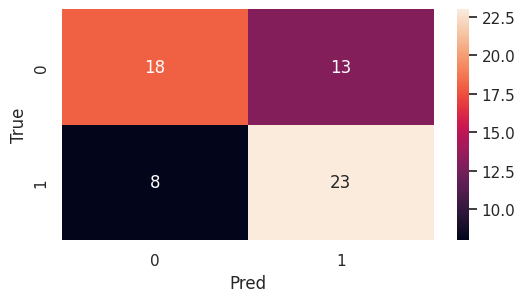

Length of dataset: 62
{'zeroThreshold': 0.3331149165065125, 'sumThreshold': 49.74763066201184, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': True}
mean pos: 89.37747210841025, std pos: 116.49759618617823
mean neg: 43.949309097182365, std neg: 89.93203707914162
lowest pos: 1.0851986408233643, highest pos: 562.4619140625
lowest neg: 0.0, highest neg: 480.43109130859375
accuracy: 0.6774193548387096
precision: 0.72
recall: 0.5806451612903226
f1: 0.6428571428571428


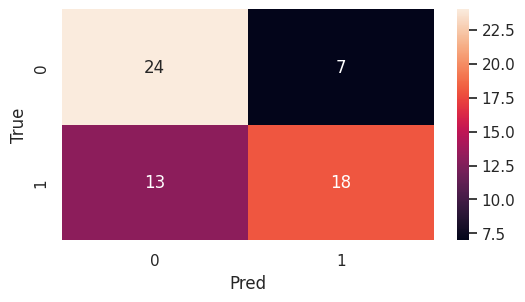

Length of dataset: 62
{'zeroThreshold': 0.17969514953272753, 'sumThreshold': 45.648618877804196, 'lossFn': 'L1', 'gaussianFilterSize': 5, 'gaussianFilterSigma': 3, 'filter': 'MinFilter', 'distinctCAETraining': True, 'cameras': ['NEN1', 'SBU3'], 'balanced': False}
mean pos: 162.06970067178048, std pos: 142.04675439799738
mean neg: 121.95219016844227, std neg: 192.8669996801229
lowest pos: 20.550073623657227, highest pos: 719.0314331054688
lowest neg: 1.979926586151123, highest neg: 989.4732666015625
accuracy: 0.6774193548387096
precision: 0.627906976744186
recall: 0.8709677419354839
f1: 0.7297297297297297


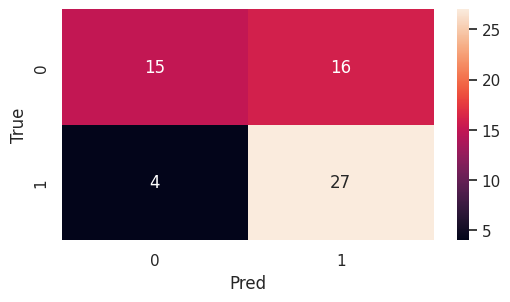

mean pos: [97.04173204591197, 89.37747210841025, 162.06970067178048],
std pos: [118.88689853848709, 116.49759618617823, 142.04675439799738]


/tmp/ipykernel_503004/1780878906.py:128: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos", color="cornflowerblue")
/tmp/ipykernel_503004/1780878906.py:129: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg", color="tomato")


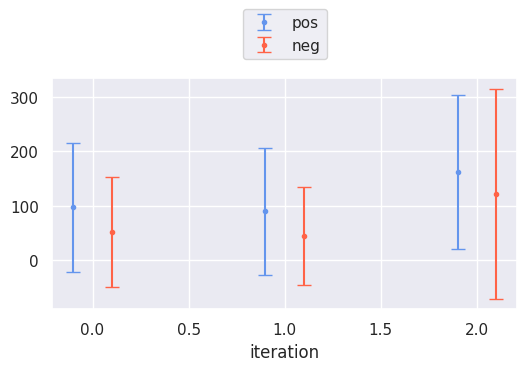

In [5]:
#TODO: include camerProps

# confMat = ConfusionMatrix(task="binary", num_classes=2)
unnorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

negVals = {
    "mean": [],
    "std": [],
    "min": [],
    "max": [],
    "median": []
}
posVals = {
    "mean": [],
    "std": [],
    "min": [],
    "max": [],
    "median": []
}

for params in sampler:
    dataset = DatasetThreeConsecutive(cameras=params["cameras"], resize_to=CAEV1.imsize, **loaderParams)
    print(f'Length of dataset: {len(dataset)}')
    print(params)
    dataLoader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

    blur = GaussianBlur(kernel_size=5, sigma=3) #TODO: make this a parameter
    lossFn = F.mse_loss if params["lossFn"] == "MSE" else F.l1_loss
    vals = []

    for (imArr, lblArr, camera, ImagePath) in dataLoader:
        isTrainingCamera = camera in caeLoaded.hparams.cameras
        prevImg = imArr[0] #alwasy #batch_size images
        currImg = imArr[1]
        nextImg = imArr[2]

        prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
        prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]

        # plt.imshow(currImg[0].cpu().detach().numpy().transpose(1, 2, 0))
        # plt.show()

        prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
        # plt.imshow(currImgBlurred[0].cpu().detach().numpy().transpose(1, 2, 0))
        # plt.show()
        
        prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

        prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
        nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

        prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2.0)
        # print(f'min: {torch.min(prevNextCurrImd).item()}')

        prevNextCurrImdMin = torch.stack([min_filter(x, kernel_size=3) for x in prevNextCurrImd])
        

        # plt.imshow(prevNextCurrImdMin[0].cpu().detach().numpy(), cmap="hot")
        # print(torch.sum(prevNextCurrImdMin[0]).item())
        # plt.show()
        # plt.imshow(prevNextCurrImdMin[1].cpu().detach().numpy(), cmap="hot")
        # print(torch.sum(prevNextCurrImdMin[1]).item())
        # plt.show()

        # prevNextCurrImdMin = torch.div(prevNextCurrImdMin, 255)
        # plt.imshow(prevNextCurrImdMin[0].cpu().detach().numpy(), cmap="hot")
        # plt.show()

        # print(torch.max(prevNextCurrImdMin))
        prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
        # plt.imshow(prevNextCurrImdMinThresh[0].cpu().detach().numpy(), cmap="hot")
        # plt.show()
        # print(f'min: {torch.min(prevNextCurrImdMinThresh).item()}')
        sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
        predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)


        for i in range(len(predictions)):
            vals.append([lblArr[i].item(), predictions[i].item(), sumPrevNextCurrImdMin[i].item()])
        #     dfNew = pd.DataFrame(columns=columns, )
        #     dfNew = df.append(dict(zip(columns, [lblArr[i].item(), predictions[i].item(), ImagePath[i], includeCameraProps, checkPoint, isTrainingCamera] + list(loaderParams.values()) + list(params.values()))), ignore_index=True)
        
        # df.to_csv(f"/data/tim/heronWorkspace/caeTestData/{fileName}.csv", index=False)

        # print(predictions)
        # print(prevNextCurrImdMin.shape)
        # print(torch.max(prevNextCurrImdMin))
        # print(imArr[0].shape)
        # print(len(imArr))
        # print(len(lblArr))

    # confMat
    vals = np.array(vals)
    # print(vals)
    # print(vals[:, 0])
    # print(vals[:, 1])
    confMat = confusion_matrix(vals[:, 0], vals[:,1])
    fig= plt.figure(figsize = (6,3))
    ax = fig.add_subplot(111)
    sns.heatmap(confMat, annot=True)
    ax.set_xlabel('Pred', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    onlyPos = vals[vals[:, 0] == 1]
    onlyNeg = vals[vals[:, 0] == 0]
    print(f'mean pos: {np.mean(onlyPos[:, 2])}, std pos: {np.std(onlyPos[:, 2])}')
    print(f'mean neg: {np.mean(onlyNeg[:, 2])}, std neg: {np.std(onlyNeg[:, 2])}')
    print(f'median pos: {np.median(onlyPos[:, 2])}, median neg: {np.median(onlyNeg[:, 2])}')
    print(f'lowest pos: {np.min(onlyPos[:, 2])}, highest pos: {np.max(onlyPos[:, 2])}')
    print(f'lowest neg: {np.min(onlyNeg[:, 2])}, highest neg: {np.max(onlyNeg[:, 2])}')

    posVals["meaean"].append(np.mean(onlyPos[:, 2]))
    posVals["std"].append(np.std(onlyPos[:, 2]))
    posVals["min"].append(np.min(onlyPos[:, 2]))
    posVals["max"].append(np.max(onlyPos[:, 2]))
    posVals["median"].append(np.median(onlyPos[:, 2]))

    negVals["mean"].append(np.mean(onlyNeg[:, 2]))
    negVals["std"].append(np.std(onlyNeg[:, 2]))
    negVals["min"].append(np.min(onlyNeg[:, 2]))
    negVals["max"].append(np.max(onlyNeg[:, 2]))
    negVals["m"].append(np.max(onlyNeg[:, 2]))

    print(f'accuracy: {accuracy_score(vals[:, 0], vals[:,1])}')
    print(f'precision: {precision_score(vals[:, 0], vals[:,1])}')
    print(f'recall: {recall_score(vals[:, 0], vals[:,1])}')
    print(f'f1: {f1_score(vals[:, 0], vals[:,1])}')
    plt.show()
    vals = []


fig = plt.figure(figsize = (len(params),3))
plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)", color="tomato")
plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)", color="cornflowerblue")
plt.plot([i-0.1 for i in range(len(posVals["mean"]))], posVals["median"], '*', color="black", label="median")
plt.plot([i+0.1 for i in range(len(negVals["mean"]))], negVals["median"], '*', color="black")

plt.xticks(range(len(sampler)))
plt.xlabel("setting")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05))
plt.show()

# confusionMatrix
# confMat = confusion_matrix(df["trueLbl"], df["predictedLbl"])
# plt.figure(figsize = (6,3))
# sns.heatmap(confMat, annot=True)
# plt.show()

# Evalution of different params

only change one param at once and plot the behaviour (error plot)

In [ ]:
#TODO: include camerProps

def evaluateAndPlotSettings(settings: [dict]):
    unnorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    negVals = {
            "mean": [],
            "std": [],
            "min": [],
            "max": [],
            "median": []
        }
    posVals = {
        "mean": [],
        "std": [],
        "min": [],
        "max": [],
        "median": []
    }
    recallArr = []
    precisionArr = []
    for params in settings:
        dataset = DatasetThreeConsecutive(cameras=params["cameras"], resize_to=CAEV1.imsize, **loaderParams)
        print(f'Length of dataset: {len(dataset)}')
        print(params)
        dataLoader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

        blur = GaussianBlur(kernel_size=params["gaussianFilterSize"], sigma=params["gaussianFilterSigma"]) #TODO: make this a parameter
        lossFn = F.mse_loss if params["lossFn"] == "MSE" else F.l1_loss
        vals = []
        for (imArr, lblArr, camera, ImagePath) in dataLoader:
            isTrainingCamera = camera in caeLoaded.hparams.cameras
            prevImg = imArr[0] #alwasy #batch_size images
            currImg = imArr[1]
            nextImg = imArr[2]

            prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
            prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]


            prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
        
            
            prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

            prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
            nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

            prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

            prevNextCurrImdMin = torch.stack([min_filter(x, kernel_size=3) for x in prevNextCurrImd]) #TODO: evtl make this as before
            

            
            prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
            

            sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
            predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)


            for i in range(len(predictions)):
                vals.append([lblArr[i].item(), predictions[i].item(), sumPrevNextCurrImdMin[i].item()])
        
        vals = np.array(vals)
        
        confMat = confusion_matrix(vals[:, 0], vals[:,1])
        fig= plt.figure(figsize = (6,3))
        ax = fig.add_subplot(111)
        sns.heatmap(confMat, annot=True)
        plt.gca().collections[0].set_clim(0, len(dataset)/2)
        ax.set_xlabel('Pred', fontsize=12)
        ax.set_ylabel('True', fontsize=12)
        onlyPos = vals[vals[:, 0] == 1]
        onlyNeg = vals[vals[:, 0] == 0]
        print(f'mean pos: {np.mean(onlyPos[:, 2])}, std pos: {np.std(onlyPos[:, 2])}')
        print(f'mean neg: {np.mean(onlyNeg[:, 2])}, std neg: {np.std(onlyNeg[:, 2])}')
        print(f'median pos: {np.median(onlyPos[:, 2])}, median neg: {np.median(onlyNeg[:, 2])}')
        print(f'lowest pos: {np.min(onlyPos[:, 2])}, highest pos: {np.max(onlyPos[:, 2])}')
        print(f'lowest neg: {np.min(onlyNeg[:, 2])}, highest neg: {np.max(onlyNeg[:, 2])}')

        posVals["mean"].append(np.mean(onlyPos[:, 2]))
        posVals["std"].append(np.std(onlyPos[:, 2]))
        posVals["min"].append(np.min(onlyPos[:, 2]))
        posVals["max"].append(np.max(onlyPos[:, 2]))
        posVals["median"].append(np.median(onlyPos[:, 2]))

        negVals["mean"].append(np.mean(onlyNeg[:, 2]))
        negVals["std"].append(np.std(onlyNeg[:, 2]))
        negVals["min"].append(np.min(onlyNeg[:, 2]))
        negVals["max"].append(np.max(onlyNeg[:, 2]))
        negVals["median"].append(np.median(onlyNeg[:, 2]))

        recallArr.append(recall_score(vals[:, 0], vals[:,1]))
        precisionArr.append(precision_score(vals[:, 0], vals[:,1]))

        print(f'accuracy: {accuracy_score(vals[:, 0], vals[:,1])}')
        print(f'precision: {precision_score(vals[:, 0], vals[:,1])}')
        print(f'recall: {recall_score(vals[:, 0], vals[:,1])}')
        print(f'f1: {f1_score(vals[:, 0], vals[:,1])}')
        plt.show()
        vals = []

    
    fig = plt.figure(figsize = (len(params),3))
    plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)", color="tomato")
    plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)", color="cornflowerblue")
    plt.plot([i-0.1 for i in range(len(posVals["mean"]))], posVals["median"], '*', color="black", label="median")
    plt.plot([i+0.1 for i in range(len(negVals["mean"]))], negVals["median"], '*', color="black")

    for i in range(len(recallArr)):
        plt.text(i, np.max([(posVals["mean"][i] + posVals["std"][i]), (negVals["mean"][i] + negVals["std"][i])]) + 10, f'recall = {recallArr[i]:.2f}\nprecision = {precisionArr[i]:.2f}', fontsize=8, ha='center')

    plt.xticks(range(len(settings)))
    plt.xlabel("setting")
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05))
    plt.show()


### Evaluation of different Sigmas

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'zeroThreshold': 0.33, 'sumThreshold': 50.9, 'lossFn': 'L1', 'gaussianFilterSigma': 1}
mean pos: 87.01605558395386, std pos: 111.54593016256709
mean neg: 41.04038092974694, std neg: 80.76504545178692
lowest pos: 1.1341581344604492, highest pos: 539.70849609375
lowest neg: 0.0, highest neg: 427.8656005859375
accuracy: 0.6774193548387096
precision: 0.7391304347826086
recall: 0.5483870967741935
f1: 0.6296296296296297


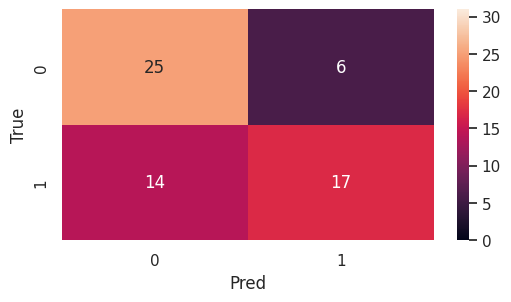

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'zeroThreshold': 0.33, 'sumThreshold': 50.9, 'lossFn': 'L1', 'gaussianFilterSigma': 3}
mean pos: 90.19005888508212, std pos: 116.53162185051957
mean neg: 44.97617345279263, std neg: 91.18523099686581
lowest pos: 1.0851986408233643, highest pos: 562.4619140625
lowest neg: 0.0, highest neg: 486.3947448730469
accuracy: 0.6774193548387096
precision: 0.72
recall: 0.5806451612903226
f1: 0.6428571428571428


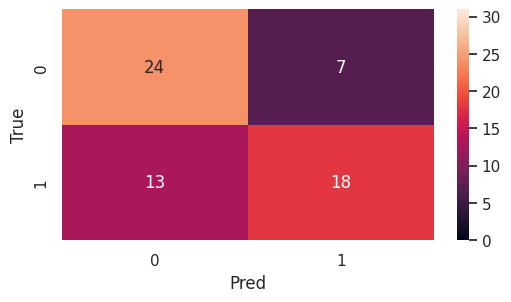

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'zeroThreshold': 0.33, 'sumThreshold': 50.9, 'lossFn': 'L1', 'gaussianFilterSigma': 5}
mean pos: 89.84929686207926, std pos: 117.1241867203918
mean neg: 44.701222415893305, std neg: 90.9991513021955
lowest pos: 1.075361967086792, highest pos: 567.4938354492188
lowest neg: 0.0, highest neg: 485.4342956542969
accuracy: 0.6774193548387096
precision: 0.72
recall: 0.5806451612903226
f1: 0.6428571428571428


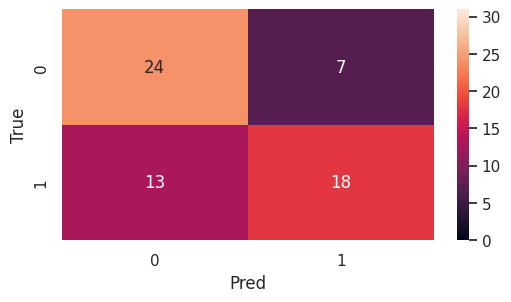

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'zeroThreshold': 0.33, 'sumThreshold': 50.9, 'lossFn': 'L1', 'gaussianFilterSigma': 7}
mean pos: 89.73489595997718, std pos: 117.19019590767087
mean neg: 44.34649059464854, std neg: 90.30766624231795
lowest pos: 1.0726349353790283, highest pos: 568.3015747070312
lowest neg: 0.0, highest neg: 481.718017578125
accuracy: 0.6774193548387096
precision: 0.72
recall: 0.5806451612903226
f1: 0.6428571428571428


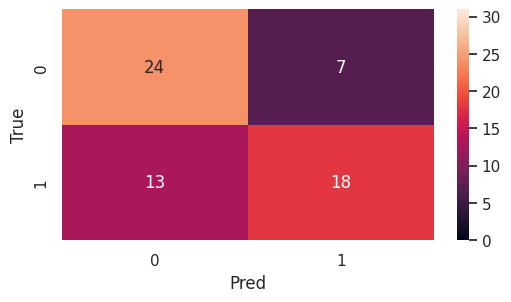

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'zeroThreshold': 0.33, 'sumThreshold': 50.9, 'lossFn': 'L1', 'gaussianFilterSigma': 9}
mean pos: 89.64635612887722, std pos: 117.27047340977958
mean neg: 44.34763719958644, std neg: 90.33406953380185
lowest pos: 1.0715126991271973, highest pos: 568.89111328125
lowest neg: 0.0, highest neg: 481.86328125
accuracy: 0.6774193548387096
precision: 0.72
recall: 0.5806451612903226
f1: 0.6428571428571428


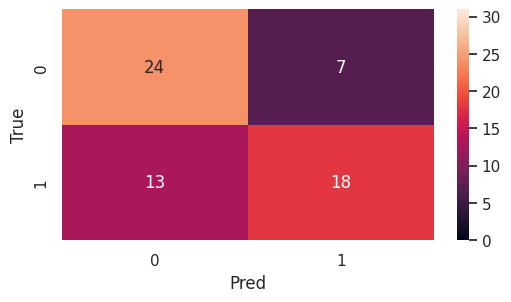

/tmp/ipykernel_503004/3860864987.py:105: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)", color="tomato")
/tmp/ipykernel_503004/3860864987.py:106: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)", color="cornflowerblue")


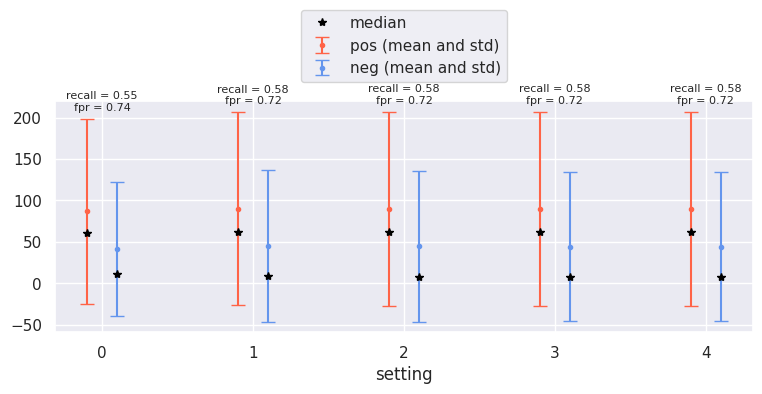

In [37]:
# distributions = dict(
#     cameras = [["NEN1", "SBU3"]], #, ["SBU4"]
#     balanced = [True, False],
#     distinctCAETraining = [True, False],
#     gaussianFilterSize = [5],
#     gaussianFilterSigma = [3, 5],
#     filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
#     zeroThreshold = np.random.uniform(low=0.15, high=0.4, size=30), # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
#     sumThreshold = np.random.uniform(low=20, high=50, size=30),
#     lossFn = ["L1"]#["MSE", "L1"],
# )

# investigation of gaussian filter sigma
startState = dict(
    cameras = ["NEN1", "SBU3"], #, ["SBU4"]
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSize = 5,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    zeroThreshold = 0.175, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    sumThreshold = 50.9,
    lossFn = "L1"
)

sigmaArr = [1, 3, 5, 7, 9]
settings = [dict(startState, gaussianFilterSigma=sigma) for sigma in sigmaArr]
evaluateAndPlotSettings(settings)

### evaluation of different Means for the Gaussian Filter

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 1, 'filter': 'MinFilter', 'zeroThreshold': 0.31, 'sumThreshold': 120, 'lossFn': 'L1', 'gaussianFilterSize': 3}
mean pos: 89.23617697531178, std pos: 110.65572900201154
mean neg: 42.0238933822801, std neg: 78.68936170123622
lowest pos: 1.4729993343353271, highest pos: 538.9820556640625
lowest neg: 0.0, highest neg: 411.7356872558594
accuracy: 0.5161290322580645
precision: 0.5555555555555556
recall: 0.16129032258064516
f1: 0.25


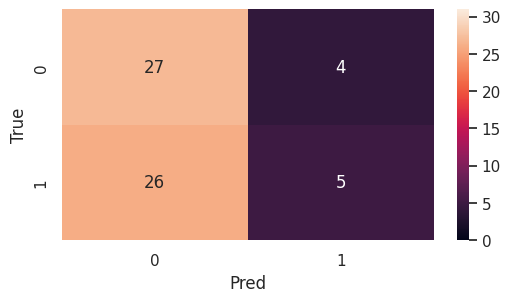

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 1, 'filter': 'MinFilter', 'zeroThreshold': 0.31, 'sumThreshold': 120, 'lossFn': 'L1', 'gaussianFilterSize': 5}
mean pos: 92.5161846914599, std pos: 113.32126549884195
mean neg: 46.069465687198026, std neg: 88.85802295633187
lowest pos: 2.401731252670288, highest pos: 548.966796875
lowest neg: 0.0, highest neg: 468.97540283203125
accuracy: 0.5161290322580645
precision: 0.5555555555555556
recall: 0.16129032258064516
f1: 0.25


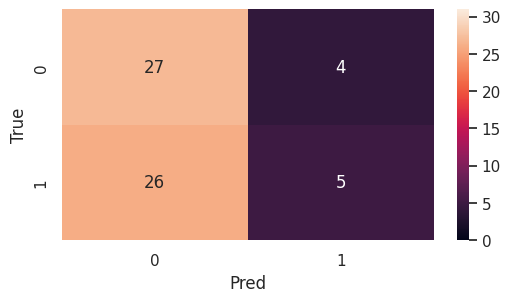

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 1, 'filter': 'MinFilter', 'zeroThreshold': 0.31, 'sumThreshold': 120, 'lossFn': 'L1', 'gaussianFilterSize': 7}
mean pos: 92.5249579183517, std pos: 113.29924038227891
mean neg: 45.96846571853084, std neg: 89.01087966951474
lowest pos: 2.3867268562316895, highest pos: 549.4750366210938
lowest neg: 0.0, highest neg: 469.6361083984375
accuracy: 0.5161290322580645
precision: 0.5555555555555556
recall: 0.16129032258064516
f1: 0.25


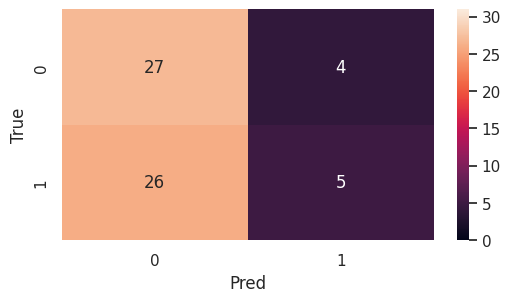

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 1, 'filter': 'MinFilter', 'zeroThreshold': 0.31, 'sumThreshold': 120, 'lossFn': 'L1', 'gaussianFilterSize': 9}
mean pos: 92.50684979654127, std pos: 113.28285062803401
mean neg: 45.923278410588544, std neg: 88.90054216007483
lowest pos: 2.38607120513916, highest pos: 549.42724609375
lowest neg: 0.0, highest neg: 468.98577880859375
accuracy: 0.5161290322580645
precision: 0.5555555555555556
recall: 0.16129032258064516
f1: 0.25


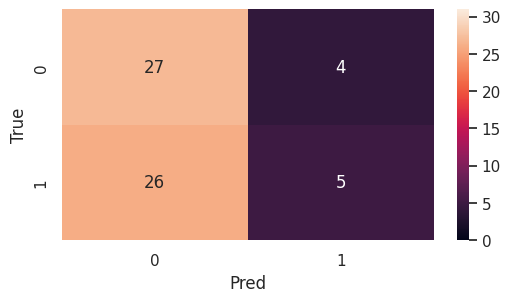

/tmp/ipykernel_503004/3860864987.py:105: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)", color="tomato")
/tmp/ipykernel_503004/3860864987.py:106: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)", color="cornflowerblue")


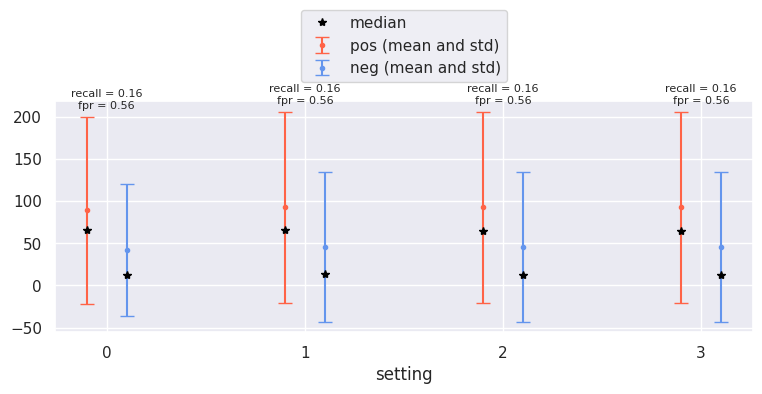

In [36]:
# distributions = dict(
#     cameras = [["NEN1", "SBU3"]], #, ["SBU4"]
#     balanced = [True, False],
#     distinctCAETraining = [True, False],
#     gaussianFilterSize = [5],
#     gaussianFilterSigma = [3, 5],
#     filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
#     zeroThreshold = np.random.uniform(low=0.15, high=0.4, size=30), # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
#     sumThreshold = np.random.uniform(low=20, high=50, size=30),
#     lossFn = ["L1"]#["MSE", "L1"],
# )

# investigation of gaussian filter sigma
startState = dict(
    cameras = ["NEN1", "SBU3"], #, ["SBU4"]
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSigma = 1,
    filter = "MinFilter", #["MinFilter", "GaussianFilter"]
    zeroThreshold = 0.31, # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    sumThreshold = 120,
    lossFn = "L1"
)

sizeArr = [3, 5, 7, 9]
settings = [dict(startState, gaussianFilterSize=size) for size in sizeArr]
evaluateAndPlotSettings(settings)

### evaluation of different zeroThresholds

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.0}
mean pos: 654.1441483036165, std pos: 279.03600074473025
mean neg: 583.6721388293851, std neg: 416.37684144780945
lowest pos: 217.71099853515625, highest pos: 1626.04052734375
lowest neg: 174.86001586914062, highest neg: 2171.205810546875
accuracy: 0.5
precision: 0.5
recall: 1.0
f1: 0.6666666666666666


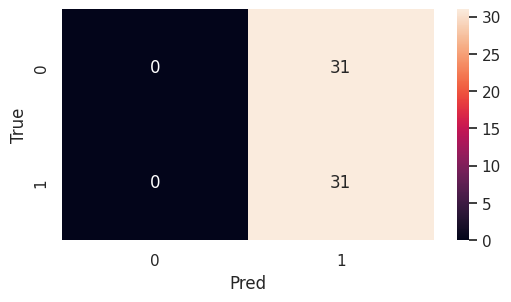

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.025}
mean pos: 512.9383923930507, std pos: 263.36736817219986
mean neg: 464.12313325943484, std neg: 412.180354574509
lowest pos: 128.03038024902344, highest pos: 1442.83349609375
lowest neg: 100.68358612060547, highest neg: 2047.263427734375
accuracy: 0.5
precision: 0.5
recall: 1.0
f1: 0.6666666666666666


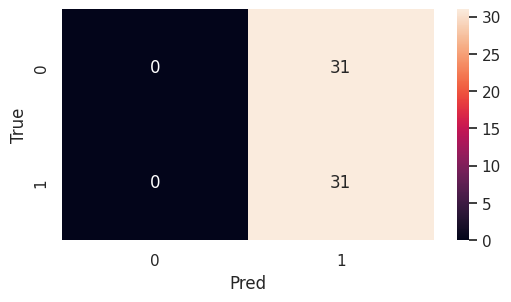

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.05}
mean pos: 394.8067651564075, std pos: 228.8121490919285
mean neg: 363.68776186050906, std neg: 376.0714169041785
lowest pos: 85.64323425292969, highest pos: 1220.64404296875
lowest neg: 66.23428344726562, highest neg: 1852.939208984375
accuracy: 0.5
precision: 0.5
recall: 1.0
f1: 0.6666666666666666


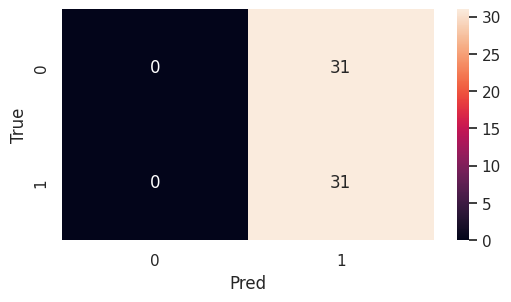

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.07500000000000001}
mean pos: 314.71019966371597, std pos: 199.75489926957317
mean neg: 287.1795816729146, std neg: 332.3944115435666
lowest pos: 61.342185974121094, highest pos: 1056.997802734375
lowest neg: 37.23863983154297, highest neg: 1634.9183349609375
accuracy: 0.5806451612903226
precision: 0.543859649122807
recall: 1.0
f1: 0.7045454545454546


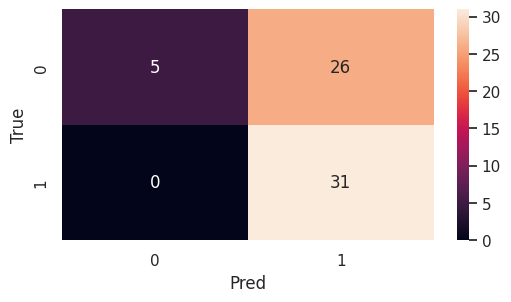

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.1}
mean pos: 258.48716834283647, std pos: 178.82901880418686
mean neg: 229.8040731491581, std neg: 292.988766480992
lowest pos: 47.59779357910156, highest pos: 935.3101806640625
lowest neg: 20.16667938232422, highest neg: 1451.78662109375
accuracy: 0.5967741935483871
precision: 0.5555555555555556
recall: 0.967741935483871
f1: 0.7058823529411765


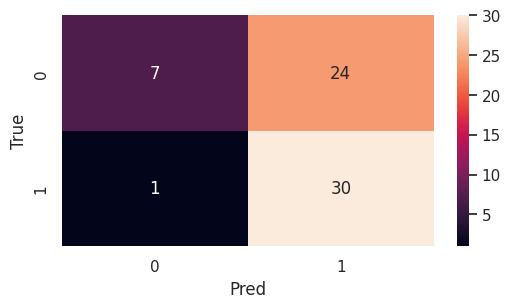

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.125}
mean pos: 217.91788310389364, std pos: 163.2390901950364
mean neg: 185.60434199917702, std neg: 255.15074970517185
lowest pos: 35.78887939453125, highest pos: 844.913330078125
lowest neg: 10.776912689208984, highest neg: 1278.52685546875
accuracy: 0.6451612903225806
precision: 0.5882352941176471
recall: 0.967741935483871
f1: 0.7317073170731707


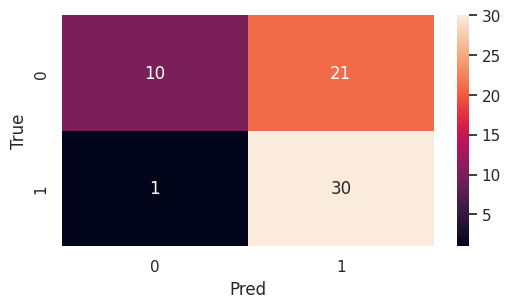

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.15000000000000002}
mean pos: 188.46788818605484, std pos: 153.2457464182148
mean neg: 151.5972735035804, std neg: 223.5280146699196
lowest pos: 27.685182571411133, highest pos: 785.441162109375
lowest neg: 3.8129515647888184, highest neg: 1130.275634765625
accuracy: 0.6451612903225806
precision: 0.6046511627906976
recall: 0.8387096774193549
f1: 0.7027027027027026


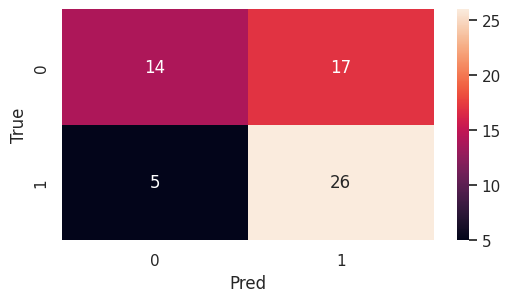

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.17500000000000002}
mean pos: 165.90064485611455, std pos: 144.3134320433503
mean neg: 125.54540477260467, std neg: 197.36168722030837
lowest pos: 20.679237365722656, highest pos: 731.921875
lowest neg: 1.9213790893554688, highest neg: 1011.23974609375
accuracy: 0.6774193548387096
precision: 0.6410256410256411
recall: 0.8064516129032258
f1: 0.7142857142857142


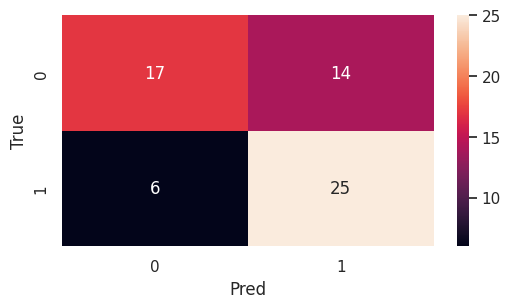

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.2}
mean pos: 146.74210166931152, std pos: 137.0740657358092
mean neg: 104.87358098260817, std neg: 173.4365879037486
lowest pos: 17.534564971923828, highest pos: 686.9458618164062
lowest neg: 0.8929457664489746, highest neg: 895.8701171875
accuracy: 0.6612903225806451
precision: 0.6388888888888888
recall: 0.7419354838709677
f1: 0.6865671641791045


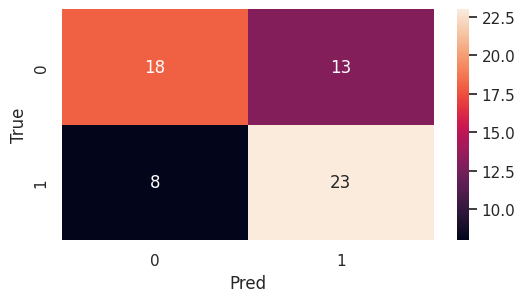

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.225}
mean pos: 131.39923049557595, std pos: 131.8961815942678
mean neg: 87.5414791655156, std neg: 151.96493370752853
lowest pos: 11.20262622833252, highest pos: 653.7340087890625
lowest neg: 0.2899364233016968, highest neg: 789.9520263671875
accuracy: 0.6129032258064516
precision: 0.6129032258064516
recall: 0.6129032258064516
f1: 0.6129032258064516


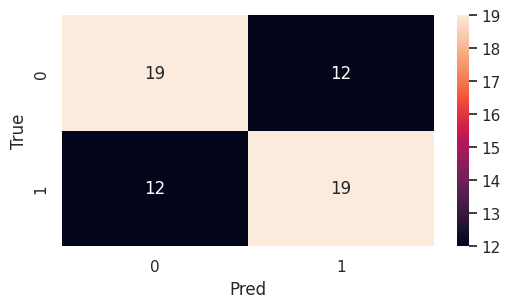

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.25}
mean pos: 118.92030755935177, std pos: 126.80929388301506
mean neg: 74.32948968198991, std neg: 134.5034187838769
lowest pos: 6.955841064453125, highest pos: 622.5211791992188
lowest neg: 0.0, highest neg: 703.73779296875
accuracy: 0.6290322580645161
precision: 0.6333333333333333
recall: 0.6129032258064516
f1: 0.6229508196721313


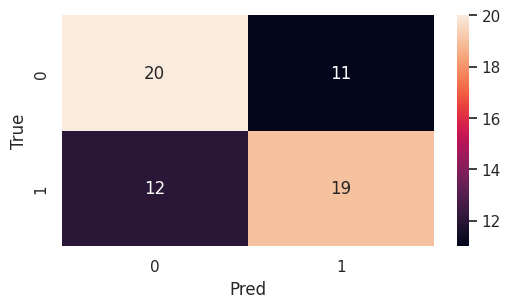

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.275}
mean pos: 108.02088212966919, std pos: 123.28875181437628
mean neg: 63.71968461428919, std neg: 120.22829748886346
lowest pos: 4.083064556121826, highest pos: 601.6979370117188
lowest neg: 0.0, highest neg: 632.023193359375
accuracy: 0.6774193548387096
precision: 0.7037037037037037
recall: 0.6129032258064516
f1: 0.6551724137931035


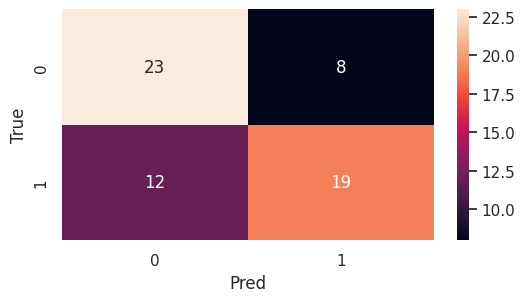

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.30000000000000004}
mean pos: 99.29172037109252, std pos: 119.98210367171717
mean neg: 53.84498450448436, std neg: 105.16104759600897
lowest pos: 1.706842064857483, highest pos: 584.7605590820312
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6774193548387096
precision: 0.72
recall: 0.5806451612903226
f1: 0.6428571428571428


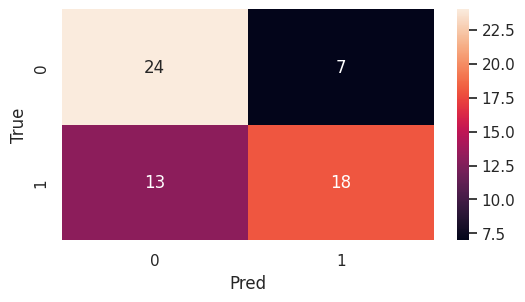

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.325}
mean pos: 91.59163428121998, std pos: 117.58181842703976
mean neg: 46.021109504084436, std neg: 92.49240851207058
lowest pos: 1.392770767211914, highest pos: 569.7811279296875
lowest neg: 0.0, highest neg: 491.98931884765625
accuracy: 0.6774193548387096
precision: 0.7619047619047619
recall: 0.5161290322580645
f1: 0.6153846153846153


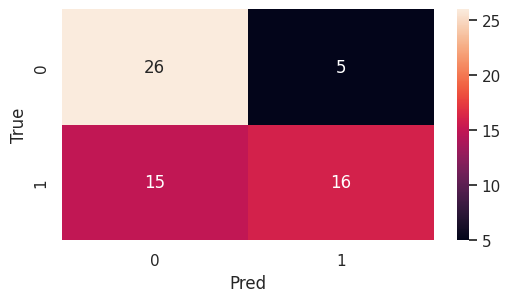

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.35000000000000003}
mean pos: 84.19762304905922, std pos: 115.18455917961413
mean neg: 39.10504220954834, std neg: 81.83202041914508
lowest pos: 0.39162319898605347, highest pos: 557.705078125
lowest neg: 0.0, highest neg: 438.238525390625
accuracy: 0.6290322580645161
precision: 0.7222222222222222
recall: 0.41935483870967744
f1: 0.5306122448979592


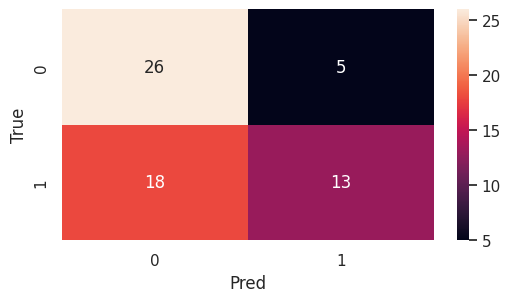

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.375}
mean pos: 78.01718286352772, std pos: 113.356208963625
mean neg: 33.03049355168496, std neg: 70.94523949800227
lowest pos: 0.0, highest pos: 548.7262573242188
lowest neg: 0.0, highest neg: 382.28173828125
accuracy: 0.6451612903225806
precision: 0.7647058823529411
recall: 0.41935483870967744
f1: 0.5416666666666666


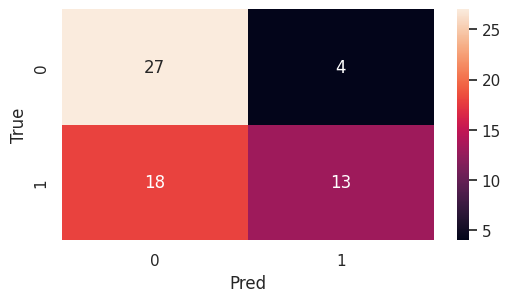

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.4}
mean pos: 72.64001294682103, std pos: 110.81713594363963
mean neg: 28.03455546690572, std neg: 61.27803711358119
lowest pos: 0.0, highest pos: 538.2967529296875
lowest neg: 0.0, highest neg: 331.92034912109375
accuracy: 0.6290322580645161
precision: 0.75
recall: 0.3870967741935484
f1: 0.5106382978723403


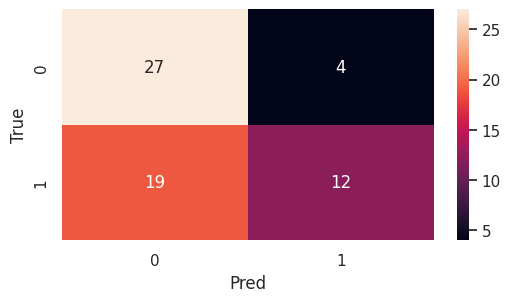

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.42500000000000004}
mean pos: 67.23199176980603, std pos: 108.95261940283068
mean neg: 23.51855697266517, std neg: 51.04920180818117
lowest pos: 0.0, highest pos: 530.455810546875
lowest neg: 0.0, highest neg: 275.1309814453125
accuracy: 0.6129032258064516
precision: 0.7333333333333333
recall: 0.3548387096774194
f1: 0.47826086956521735


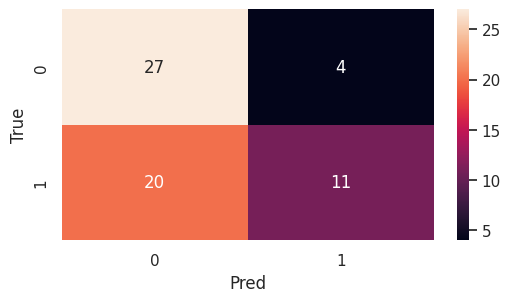

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.45}
mean pos: 63.17166145386234, std pos: 107.53175398304421
mean neg: 19.12939344298455, std neg: 43.049869098036275
lowest pos: 0.0, highest pos: 524.3631591796875
lowest neg: 0.0, highest neg: 232.76788330078125
accuracy: 0.6451612903225806
precision: 0.8461538461538461
recall: 0.3548387096774194
f1: 0.5


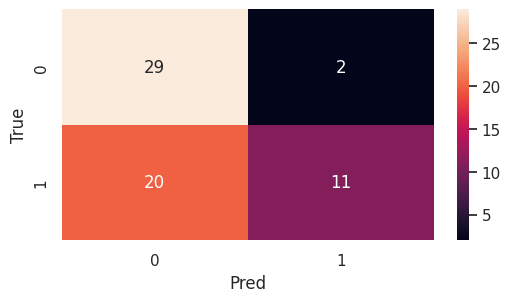

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'filter': 'MinFilter', 'sumThreshold': 60, 'lossFn': 'L1', 'zeroThreshold': 0.47500000000000003}
mean pos: 58.89567435941389, std pos: 105.60933955778673
mean neg: 15.709721057645735, std neg: 36.78956816435208
lowest pos: 0.0, highest pos: 518.321533203125
lowest neg: 0.0, highest neg: 200.40188598632812
accuracy: 0.6290322580645161
precision: 0.8333333333333334
recall: 0.3225806451612903
f1: 0.4651162790697674


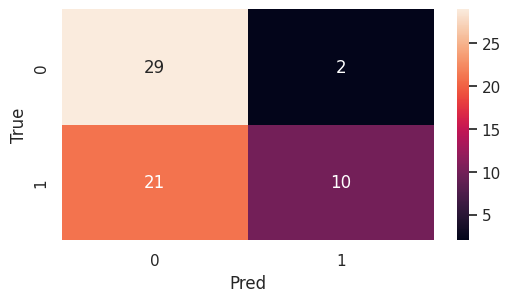

/tmp/ipykernel_503004/4285669797.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)", color="cornflowerblue")
/tmp/ipykernel_503004/4285669797.py:105: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)", color="tomato")


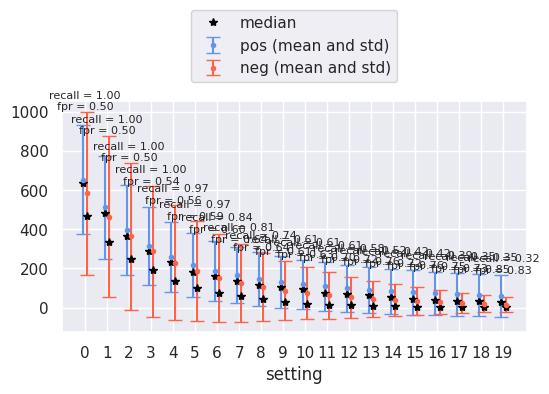

In [27]:
# distributions = dict(
#     cameras = [["NEN1", "SBU3"]], #, ["SBU4"]
#     balanced = [True, False],
#     distinctCAETraining = [True, False],
#     gaussianFilterSize = [5],
#     gaussianFilterSigma = [3, 5],
#     filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
#     zeroThreshold = np.random.uniform(low=0.15, high=0.4, size=30), # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
#     sumThreshold = np.random.uniform(low=20, high=50, size=30),
#     lossFn = ["L1"]#["MSE", "L1"],
# )

# investigation of gaussian filter sigma
startState = dict(
    cameras = ["NEN1", "SBU3"],
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSigma = 5,
    gaussianFilterSize = 5,
    filter = "MinFilter", 
    sumThreshold = 60,
    lossFn = "L1"
)
zeroThresholdArr = np.arange(0, 0.5, 0.025)
settings = [dict(startState, zeroThreshold=zeroThreshold) for zeroThreshold in zeroThresholdArr]
evaluateAndPlotSettings(settings)

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 20}
mean pos: 99.29172006345564, std pos: 119.98210379641166
mean neg: 53.84498514090815, std neg: 105.16104807334015
lowest pos: 1.706842064857483, highest pos: 584.7605590820312
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6774193548387096
precision: 0.6410256410256411
recall: 0.8064516129032258
f1: 0.7142857142857142


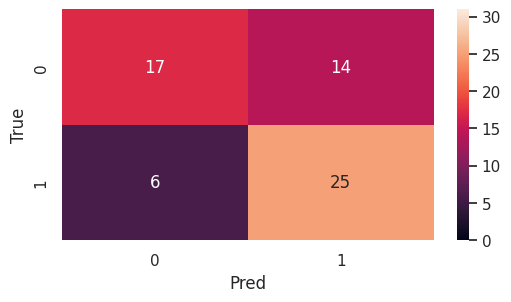

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 30}
mean pos: 99.29172186313137, std pos: 119.98211171737199
mean neg: 53.84498514763771, std neg: 105.16104805569746
lowest pos: 1.706842064857483, highest pos: 584.7606201171875
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6612903225806451
precision: 0.6388888888888888
recall: 0.7419354838709677
f1: 0.6865671641791045


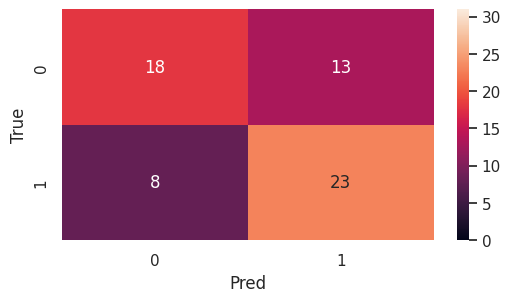

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 40}
mean pos: 99.29171943280005, std pos: 119.98210322694437
mean neg: 53.84498521877873, std neg: 105.16104807793992
lowest pos: 1.706842064857483, highest pos: 584.7605590820312
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6451612903225806
precision: 0.6451612903225806
recall: 0.6451612903225806
f1: 0.6451612903225806


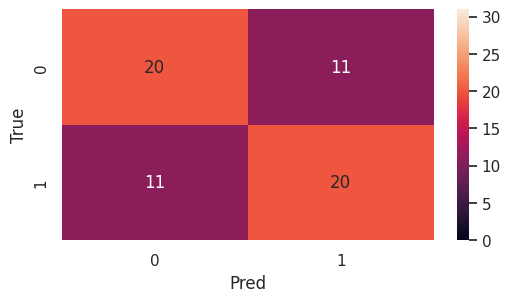

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 50}
mean pos: 99.29172087484791, std pos: 119.98210592650392
mean neg: 53.84498461984819, std neg: 105.16104755696782
lowest pos: 1.7068419456481934, highest pos: 584.7605590820312
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6774193548387096
precision: 0.7037037037037037
recall: 0.6129032258064516
f1: 0.6551724137931035


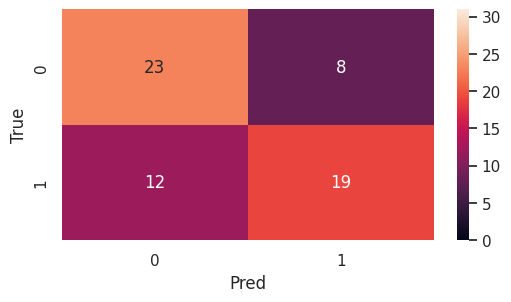

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 60}
mean pos: 99.29172154011265, std pos: 119.98211118543453
mean neg: 53.844983181645794, std neg: 105.16103864780675
lowest pos: 1.706842064857483, highest pos: 584.7606201171875
lowest neg: 0.0, highest neg: 557.0095825195312
accuracy: 0.6774193548387096
precision: 0.72
recall: 0.5806451612903226
f1: 0.6428571428571428


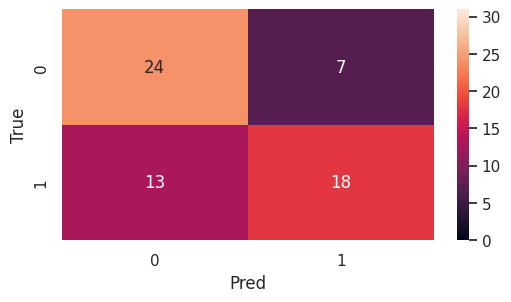

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 70}
mean pos: 99.29172009421933, std pos: 119.98210371469128
mean neg: 53.844985117835385, std neg: 105.16104808158876
lowest pos: 1.706842064857483, highest pos: 584.7605590820312
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6451612903225806
precision: 0.7142857142857143
recall: 0.4838709677419355
f1: 0.5769230769230769


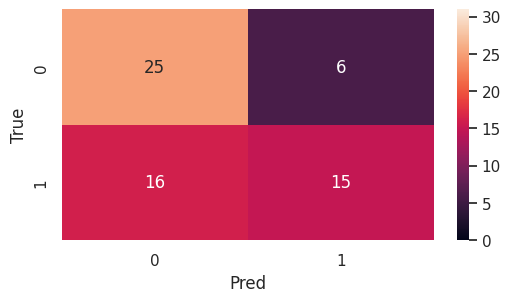

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 80}
mean pos: 99.29172227844116, std pos: 119.98211155624078
mean neg: 53.8449850649603, std neg: 105.16104810344068
lowest pos: 1.706842064857483, highest pos: 584.7606201171875
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.6612903225806451
precision: 0.75
recall: 0.4838709677419355
f1: 0.5882352941176471


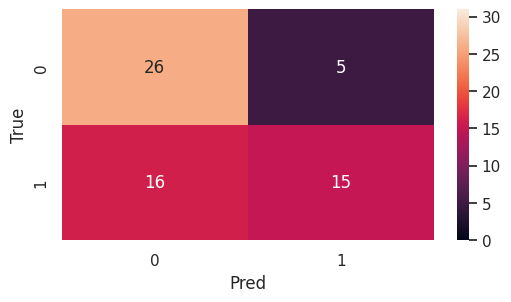

Length of dataset: 62
{'cameras': ['NEN1', 'SBU3'], 'balanced': True, 'distinctCAETraining': False, 'gaussianFilterSigma': 5, 'gaussianFilterSize': 5, 'zeroThreshold': 0.3, 'filter': 'MinFilter', 'lossFn': 'L1', 'sumThreshold': 90}
mean pos: 99.29171964814586, std pos: 119.98210322199199
mean neg: 53.84498475059386, std neg: 105.16104754853946
lowest pos: 1.706842064857483, highest pos: 584.7605590820312
lowest neg: 0.0, highest neg: 557.0096435546875
accuracy: 0.5967741935483871
precision: 0.6875
recall: 0.3548387096774194
f1: 0.4680851063829787


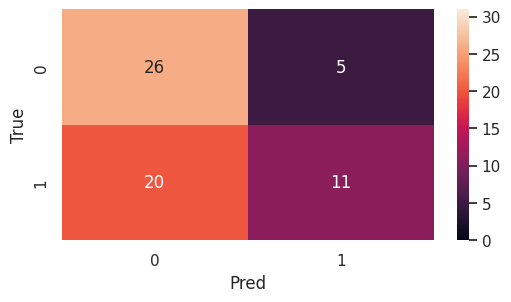

/tmp/ipykernel_503004/3860864987.py:105: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i-0.1 for i in range(len(posVals["mean"]))], posVals["mean"], yerr=posVals["std"],fmt='.k', capsize=5, label="pos (mean and std)", color="tomato")
/tmp/ipykernel_503004/3860864987.py:106: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar([i+0.1 for i in range(len(negVals["mean"]))], negVals["mean"], yerr=negVals["std"],fmt='.k', capsize=5, label="neg (mean and std)", color="cornflowerblue")


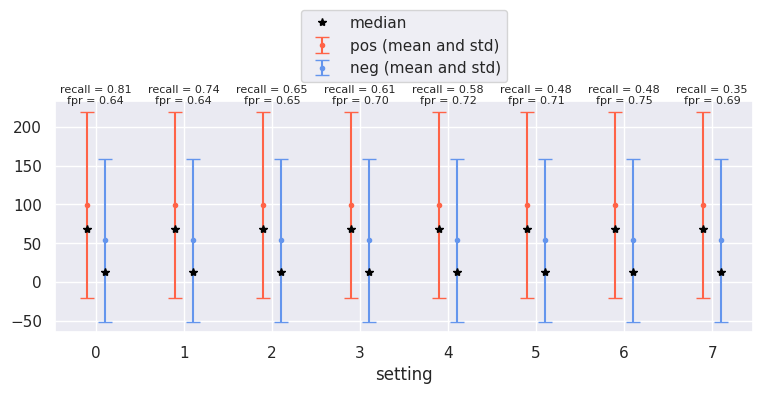

In [41]:
# distributions = dict(
#     cameras = [["NEN1", "SBU3"]], #, ["SBU4"]
#     balanced = [True, False],
#     distinctCAETraining = [True, False],
#     gaussianFilterSize = [5],
#     gaussianFilterSigma = [3, 5],
#     filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
#     zeroThreshold = np.random.uniform(low=0.15, high=0.4, size=30), # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
#     sumThreshold = np.random.uniform(low=20, high=50, size=30),
#     lossFn = ["L1"]#["MSE", "L1"],
# )

# investigation of gaussian filter sigma
startState = dict(
    cameras = ["NEN1", "SBU3"],
    balanced = True,
    distinctCAETraining = False,
    gaussianFilterSigma = 5,
    gaussianFilterSize = 5,
    zeroThreshold = 0.3,
    filter = "MinFilter", 
    lossFn = "L1"
)
sumThresholdArr = np.arange(20, 100, 10)
settings = [dict(startState, sumThreshold=sumThreshold) for sumThreshold in sumThresholdArr]
evaluateAndPlotSettings(settings)

# Evaluation of model with train, val and test set

In [ ]:
def classify(params: dict, caeModel, loaderParams, mode = "fit"):
    """
    mode: fit or predict - if fit, no sumThreshold needed
    """
    dataset = DatasetThreeConsecutive(resize_to=caeModel.imsize, **loaderParams)
    print(f'Length of dataset: {len(dataset)}')
    print(params)
    dataLoader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=2)

    blur = GaussianBlur(kernel_size=5, sigma=3) #TODO: make this a parameter
    lossFn = F.mse_loss if params["lossFn"] == "MSE" else F.l1_loss
    vals = []

    for (imArr, lblArr, camera, ImagePath) in dataLoader:
        isTrainingCamera = camera in caeLoaded.hparams.cameras
        prevImg = imArr[0] #alwasy #batch_size images
        currImg = imArr[1]
        nextImg = imArr[2]

        prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
        prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]


        prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
    
        
        prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

        prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
        nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

        prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

        prevNextCurrImdMin = torch.stack([min_filter(x, kernel_size=3) for x in prevNextCurrImd]) #TODO: evtl make this as before
        

        
        prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
        

        sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))

        if mode == "fit":

            for i in range(len(predictions)):
                vals.append([lblArr[i].item(), sumPrevNextCurrImdMin[i].item()])
        else:
            predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)

            for i in range(len(predictions)):
                vals.append([lblArr[i].item(), predictions[i].item(), sumPrevNextCurrImdMin[i].item()])
    
    vals = np.array(vals)
    return vals

In [ ]:
def plotEvalMetrics(vals: np.array):
    confMat = confusion_matrix(vals[:, 0], vals[:,1])
    fig= plt.figure(figsize = (6,3))
    ax = fig.add_subplot(111)
    sns.heatmap(confMat, annot=True)
    ax.set_xlabel('Pred', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    onlyPos = vals[vals[:, 0] == 1]
    onlyNeg = vals[vals[:, 0] == 0]
    print(f'mean pos: {np.mean(onlyPos[:, 2])}, std pos: {np.std(onlyPos[:, 2])}')
    print(f'mean neg: {np.mean(onlyNeg[:, 2])}, std neg: {np.std(onlyNeg[:, 2])}')
    print(f'lowest pos: {np.min(onlyPos[:, 2])}, highest pos: {np.max(onlyPos[:, 2])}')
    print(f'lowest neg: {np.min(onlyNeg[:, 2])}, highest neg: {np.max(onlyNeg[:, 2])}')

    posVals["mean"].append(np.mean(onlyPos[:, 2]))
    posVals["std"].append(np.std(onlyPos[:, 2]))
    posVals["min"].append(np.min(onlyPos[:, 2]))
    posVals["max"].append(np.max(onlyPos[:, 2]))

    negVals["mean"].append(np.mean(onlyNeg[:, 2]))
    negVals["std"].append(np.std(onlyNeg[:, 2]))
    negVals["min"].append(np.min(onlyNeg[:, 2]))
    negVals["max"].append(np.max(onlyNeg[:, 2]))

    print(f'accuracy: {accuracy_score(vals[:, 0], vals[:,1])}')
    print(f'precision: {precision_score(vals[:, 0], vals[:,1])}')
    print(f'recall: {recall_score(vals[:, 0], vals[:,1])}')
    print(f'f1: {f1_score(vals[:, 0], vals[:,1])}')
    plt.show()

In [ ]:
loaderParams = dict(
    lblValidationMode = "Manual",
    balanced = True,
    anomalyObviousness = "obvious",
    distinctCAETraining = False,
    colorMode = "RGB",
    random_state = 1,
    set = "all",
    cameras = ["NEN1", "SBU3"],
    balanced = True,
    distinctCAETraining = False
)

distributions = dict(
    gaussianFilterSize = [5],
    gaussianFilterSigma = [3, 5],
    filter = ["MinFilter"], #["MinFilter", "GaussianFilter"]
    zeroThreshold = np.random.uniform(low=0.15, high=0.4, size=30), # uniform dist on loc, loc+scale -> uniform(loc, scale) #threshold for zeroing out the image
    # sumThreshold = np.random.uniform(low=20, high=50, size=30),
    lossFn = ["L1"]#["MSE", "L1"],
)

sampler = ParameterSampler(distributions, n_iter=3, random_state=loaderParams["random_state"])

includeCameraProps = False
model = CAEV1

checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = model)
caeLoaded.freeze()
print(caeLoaded.hparams)

columns = ["trueLbl", "predictedLbl", "ImagePath", "includeCameraProps", "CAECheckPoint", "isCAETrainingCamera"] + list(loaderParams.keys()) + list(distributions.keys()) 

currBestParams = {}
currBestAcc = 0

for params in sampler:
    print(params)

    #Train
    print("Training")
    trainVals = classify(params=params, caeModel=caeLoaded, loaderParams=loaderParams, mode="fit")
    onlyPos = trainVals[trainVals[:, 0] == 1]
    onlyNeg = trainVals[trainVals[:, 0] == 0]
    print(f'mean pos: {np.mean(onlyPos[:, 1])}, std pos: {np.std(onlyPos[:, 1])}')
    print(f'mean neg: {np.mean(onlyNeg[:, 1])}, std neg: {np.std(onlyNeg[:, 1])}')

    newSumThreshold = (np.mean(onlyPos[:, 1]) + np.mean(onlyNeg[:, 1])) / 2

    params["sumThreshold"] = newSumThreshold

    #Validation
    print("Validation")
    valVals = classify(params=params, caeModel=caeLoaded, loaderParams=loaderParams, mode="predict")
    acc = accuracy_score(valVals[:, 0], valVals[:,1])

    if acc > currBestAcc:
        currBestParams = params
        currBestAcc = acc
    print(f'Accuracy: {acc}')

#Test
print("Test best model")
vals = classify(params=params, caeModel=caeLoaded, loaderParams=loaderParams, mode="predict")
plotEvalMetrics(vals)



In [18]:
range(len(posVals["mean"]))

range(0, 1)

In [ ]:
try:
    df = pd.read_csv("./resultsBasicClassifier.csv")
except:
    df = pd.DataFrame(columns = params.keys(), )